# IL027 Interdisciplinary Computer Modelling

## Lecture 9 (Part 2) - Introduction to ANNs in Reinforcement Learning 

### Berk Onat 
#### Warwick Predictive Modelling Centre, School of Engineering
##### Email: B.Onat@warwick.ac.uk

### Reinforcement Learning 

#### Reinforcement learning is a sub-field of Machine Learning that focuses on how an <span style="color:red">agent</span> learn to maximize the <span style="color:green">reward</span> by applying <span style="color:orange">actions</span> for a <span style="color:blue">state</span> in an `environment`.

<center><img src="imgL9/reinforce-agent.png" style="center" width=30%/></center>

(image reference: wikipedia)

### Reinforcement Learning 
Reinforcement learning is based on Markov Decision Process (MDP). In Markov Decision Process, any future event is independent of the past events where the only event considered is present. 

MDP refers to `sthocastic model` where probability of next events are solely depend on the present state. 

In reinforcement learning, the decision process based on the probability distribution of states is considered to be determined with a `policy` where an `agent` can take `actions` using this `policy`. 

Here in this Lecture, we will exercise if the policy can be determined with an ANN. 

We will train an ANN model to act as an AI that takes actions in an environment according to the state it is in.

In reinforcement learning, the Markov decision process (MDP) can be defined with ($S$, $A$, $P$, $R$) tuples as following:

$S$ : a finite set of `states` 

$A$ : a finite set of `actions`

$P(s,s') = Pr(s_{t+1} =s' | s=s_t,a=a_t)$ : the propability to transition from `s` to `s'` with action `a`.

$R(s.s')$ : the reward for the transition from $s$ to $s'$.

Here, `t` is the time step.

### Can we use Reinforcement Learning and train an `Agent` (AI) to play ball ?

|![A](imgL9/RoboKid_Play_Ball.png)|![B](imgL9/reinforce-agent.png)|
|:---:|:---:|

## We can see an example AI-agent (<span style="color:pink">pink ball</span>) that plays with <span style="color:purple">purple ball</span> in animation at left hand side. 
|![A](imgL9/AI-plays-ball.gif)|![B](imgL9/reinforce-agent.png)|
|:---:|:---:|

As in the example above, we will keep the environment very simple. 


In [1]:
using LinearAlgebra
using Colors, Combinatorics
using Plots
using FileIO
using BSON: @save, @load
using Printf
gr(fmt=:png)

Plots.GRBackend()

#### To keep the positions, velocities and other properties of balls, we define a struct.

In [2]:
mutable struct Ball
    id::Int
    pos::Vector{Float64}
    vel::Vector{Float64}
    color::Symbol
    r::Float64
    m::Float64
end

#### Here we define a function for a circle centred at (x,y) position with radius `r` .

In [3]:
function circle(x,y,r)
    theta = LinRange(0, 2*pi, 100)
    x .+ r*sin.(theta), y .+ r*cos.(theta)
end

circle (generic function with 1 method)

In [4]:
function circles_overlap(p1,r1,p2,r2)
    dx = p2[1] - p1[1]
    dy = p2[2] - p1[2]
    d = sqrt(dx*dx+dy*dy)
    rtn = false
    r12 = r1+r2
    if (d < r12)
        # circles intersect
        rtn =  true
    end
    return d, rtn
end

circles_overlap (generic function with 1 method)

### Elastic Collision

<center><img src="imgL9/elastic.gif" style="center" width=50%/></center>
(image reference: wikipedia)

In one dimensional Newtonian motion, we can consider two particles with $m_1$ and $m_2$ masses with $u_1$ and $u_2$ velocities before a collision and with $v_1$ and $v_2$ velocities after a collision.

As the total momentum is conserved before and after collision, we can write

$$ m_1u_1+m_2u_2 = m_1v_1+m_2v_2$$

<center><img src="imgL9/elastic.gif" style="center" width=40%/></center>

Similarly, the total kinetic energy of the particles is also conserved and this can be given with

$$ {1\over2}m_1u_1^2+ {1\over2}m_2u_2^2= {1\over2}m_1v_1^2+ {1\over2}m_2v_2^2$$

Solving these equations, we can determine $v_1$ and $v_2$ if $u_1$ and $u_2$ is known with

$$ v_1 = {{N}\over{M}}u_1+{{2m_2}\over{M}}u_2$$ $$v_2 = {{2m_1}\over{M}}u_1+{{-N}\over{M}}u_2$$

where $M = m_1+m_2$ and $N = m_1-m_2$.

In [5]:
function checkCollision(balls)
    any_collision = false
    collisions = []
    # First check of all collisions
    for ballpair in combinations(1:length(balls), 2)
        balla, ballb = balls[ballpair[1]], balls[ballpair[2]]
        distance, overlap = circles_overlap(balla.pos, balla.r, ballb.pos, ballb.r)
        if overlap
            any_collision = true
            collision = (ballb.pos - balla.pos) / distance
            if balla.id == 1
                balla.vel[1] = sign(rand() - 0.5) * (4.0 + 4.0 * rand())
                balla.vel[2] = 3.0 + rand() * 2.0
            end
            if ballb.id == 1
                ballb.vel[1] = sign(rand() - 0.5) * (4.0 + 4.0 * rand())
                ballb.vel[2] = 3.0 + rand() * 2.0
            end
            aci = dot(balla.vel, collision)
            bci = dot(ballb.vel, collision)
            # new velocities using the 1-dimensional elastic collision equations
            acf = bci * 2.0 * balla.m / (balla.m + ballb.m)
            bcf = aci * 2.0 * ballb.m / (balla.m + ballb.m)
            # Packing collisions here to update it later 
            pack = [
                ballpair[1], (acf - aci) * collision,
                ballpair[2], (bcf - bci) * collision
            ]
            push!(collisions, pack)
        end
    end
    # Next update all collisions
    for coll in collisions
        # replace the velocity components
        if coll[1] != 1
            balls[coll[1]].vel += coll[2]
        end
        if coll[3] != 1
            balls[coll[3]].vel += coll[4]
        end
    end
    return any_collision, balls
end

checkCollision (generic function with 1 method)

Here we update the ball positions and velocities according to the collisions and constrains on the environment.

In [6]:
function updateBalls(env)
    w = env[3][2]
    h = env[3][3]
    g = env[3][4]
    frame_second = env[3][5]
    any_collision, balls = checkCollision(env[1])
    touched_ground = false
    for (bid, ball) in enumerate(balls)
        if ball.id != 1
            ball.vel[2] -= g * frame_second
            ball.pos += ball.vel * frame_second
        else
            ball.pos[1] += ball.vel[1] * frame_second
        end
        # left edge
        if (ball.pos[1] <= ball.r)
            ball.pos = [ball.r, ball.pos[2]]
            ball.vel = [-ball.vel[1], ball.vel[2]]
        end
        # right edge
        if (ball.pos[1] >= (w - ball.r))
            ball.pos = [w - ball.r, ball.pos[2]]
            ball.vel = [-ball.vel[1], ball.vel[2]]
        end
        # bottom edge
        if (ball.pos[2] <= ball.r)
            ball.pos = [ball.pos[1], ball.r]
            ball.vel = [ball.vel[1], -ball.vel[2]]
            if ball.id != 1
                touched_ground = true
            end
        end
        # top edge
        if (ball.pos[2] >= (h - ball.r))
            ball.pos = [ball.pos[1], h - ball.r]
            ball.vel = [ball.vel[1], -ball.vel[2]]
        end
        if ball.id == 1
            #balls[bid].vel[1] = sign(rand() - 0.5) * (2.0 + 4.0 * rand())
            #balls[bid].vel[2] = 1.0 + rand() * 2.0
            balls[bid].vel[1] = 0.0
            balls[bid].vel[2] = 0.0
        else
            balls[bid].pos = ball.pos
            balls[bid].vel = ball.vel * 0.9995
        end
    end
    env[1] = balls
    if env[2] == 0 && touched_ground
        # Gameover
        #env[2] = 1
        if env[3][1] > 0
            env[3][1] -= 0.5
        end
    end
    if env[2] == 0 && any_collision
        # Update score
        env[3][1] += 1
    end
    return env
end

updateBalls (generic function with 1 method)

The game environment than is set up as below.

In [7]:
function game_setup(;time=nothing)
    # Initial values and environmental settings of the game
    w = 4 # width in m
    h = 5 # height in m
    ballradius = 0.2 # m
    ballmass = 0.01 # kg
    frame_second = 0.001 # s
    if time == nothing
        n = 10000 # number of frames
    else
        n = floor(time/0.001)
    end
    g = 9.807 # m / s^2 gravity on Earth
    snapshot_interval = 50
    score = 0
    gameover = 0 # the game is over if 1
    
    # Generating initial positions and velocities of the balls
    rnd = rand(4)
    ball1x  = rnd[1] * (w-2.0*ballradius) + ballradius
    ball1y  = rnd[2] * (h*0.5-ballradius) + h*0.49
    #ball1vx = 4.0 * (rnd[3] * 2.0 - 1.0)
    ball1vx = sign(rand() - 0.5) * (3.0 + 1.0 * rand())
    ball2x  = rnd[4] * (w-2.0*ballradius) + ballradius
    if ball1x > w*0.5 && ball2x > w*0.5
        ball1x -= w*0.5
    elseif ball1x < w*0.5 && ball2x < w*0.5
        ball1x += w*0.5
    end

    # First ball is player
    balls = [
        # set initial position and velocity vectors
        Ball(1, [ball2x, ballradius], [0, 0], :red, ballradius, ballmass),
        Ball(2, [ball1x, ball1y], [ball1vx, 0.0], :purple, ballradius, 10*ballmass),
        #Ball(3, [ball1x, ball1y], [0.0, 0.0], :blue, ballradius, ballmass),
    ]
    
    settings = [score, w, h, g, frame_second]
    sim_time = [n, snapshot_interval]
    env = [balls, gameover, settings, sim_time]
    return env
end

game_setup (generic function with 1 method)

### The visualisation of the environment is provided through the convertion of snapshots into a `gif` animation.  

In [8]:
function game_visualise(snapshots, env)
    w = env[3][2]
    h = env[3][3]
    last_id = 1
    @gif for i=1:length(snapshots)
        time = snapshots[i][1]
        touched_ground = snapshots[i][2]
        player_score = snapshots[i][3]
        balls = snapshots[i][4]
        #if !touched_ground
        #    last_id = i
        #else
        #    balls = snapshots[last_id+1][4]
        #end
        count = 1
        for ball in balls
            if count == 1
                plot(circle(ball[1][1],ball[1][2],ball[2]), seriestype = [:shape], 
                     lw = 0.5, c = ball[3], linecolor = :black, legend = false, 
                     fillalpha = 0.2, aspect_ratio = 1, xlim=(0, w), ylim=(0, h))
            else
                plot!(circle(ball[1][1],ball[1][2],ball[2]), seriestype = [:shape], 
                      lw = 0.5, c = ball[3], linecolor = :black, legend = false, 
                    fillalpha = 0.2, aspect_ratio = 1, xlim=(0, w), ylim=(0, h))
            end
            count += 1
        end
        str = @sprintf "Time: %3.1f" time
        annotate!([(w-(w*0.15), h-(0.05*h), Plots.text(str, 10, :black, :left))])
        score_str = @sprintf "Score: %d" player_score
        annotate!([(w-(w*0.15), h-(0.10*h), Plots.text(score_str, 10, :black, :left))])
        #if touched_ground == 1
        #    if i%3 == 0
        #        annotate!([(w*0.26, h*0.5, Plots.text("GAME OVER", 16, :red, :left))])
        #    elseif i%3==1
        #        annotate!([(w*0.26, h*0.5, Plots.text("GAME OVER", 16, :blue, :left))])
        #    else
        #        annotate!([(w*0.26, h*0.5, Plots.text("GAME OVER", 16, :orange, :left))])
        #    end
        #end
    end
end

game_visualise (generic function with 1 method)

### The simulation (game) environment is controlled through the function defined below. 

In [9]:
function game_run(env; brain=nothing)
    snapshots = []
    time = 0.0
    for i=1:env[4][1]
        if brain != nothing
            state = get_state(env)
            a = action(state) # ANN is here!
        else
            a = nothing
        end
        env = game_update(env; action=a)
        if i==1 || i%env[4][2]==0 || i==env[4][1]
            push!(snapshots,[time, env[2], env[3][1],
                    [[b.pos,b.r,b.color] for b in env[1]]])
        end
        time += env[3][5]
    end
    return env, snapshots
end

game_run (generic function with 1 method)

In [10]:
function get_state(env)
    state = [
        env[1][1].pos[1], # x position of player 
        #env[1][1].vel[1], # x velocity of player
        #env[2],           # Score of player
        #env[3][1],        # Time in game
        env[1][2].pos[1], # x position of the other ball
        env[1][2].pos[2]  # y position of the other ball
        #env[1][2].vel[1], # x velocity of the other ball
        #env[1][2].vel[2]  # y velocity of the other ball
    ]
    return state
end

get_state (generic function with 1 method)

In [11]:
function game_update(env; action=nothing)
    env = updateBalls(env)
    
    # Auto follow bouncing ball
    if env[1][1].pos[1] > env[1][2].pos[1]
        env[1][1].vel[1] -= 4.0
    end
    if env[1][1].pos[1] < env[1][2].pos[1]
        env[1][1].vel[1] += 4.0
    end
    
    return env
end

game_update (generic function with 1 method)

In [12]:
function game()
    env = game_setup()
    env, snapshots = game_run(env)
    game_visualise(snapshots, env)
end

game (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/eng/essmpc/.iatl/modules/IL027/IL027/tmp.gif
└ @ Plots /opt/julia/share/site/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/eng/essmpc/.iatl/modules/IL027/IL027/tmp.gif")
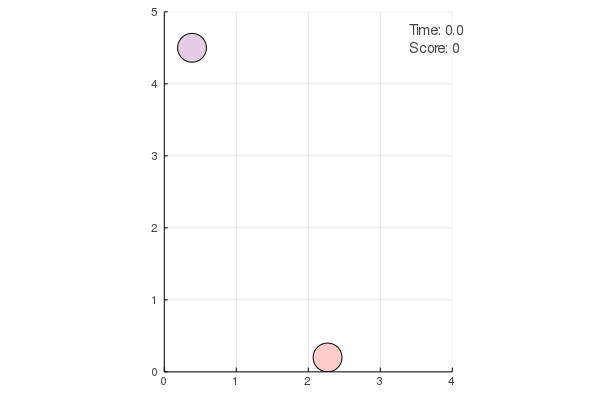

In [13]:
game()

In [14]:
function game(;brain=nothing, time=nothing)
    env = game_setup(;time=time)
    env, snapshots = game_run(env,brain=brain)
    game_visualise(snapshots, env)
end

game (generic function with 1 method)

In [15]:
function game_update(env; action=nothing)
    env = updateBalls(env)
    if action != nothing
        if action[1] < 0.0
            # move left
            env[1][1].vel[1] -= 4.0
        end
        if action[1] > 0.0
            # move right
            env[1][1].vel[1] += 4.0
        end
    end
    return env
end

game_update (generic function with 1 method)

### We will use `Flux` and `Zygote` to train our ANN model.

In [ ]:
using Flux
using Zygote
using Flux.Tracker: track, @grad, data, gradient
#using Flux.Optimise: Optimiser, _update_params!, update!
using Statistics: mean
import Base.sign

### First, we setup the environment

In [ ]:
env = game_setup()

In [ ]:
# ----------------------------- Parameters -------------------------------------

STATE_SIZE = length(get_state(env))
ACTION_SIZE = length(action_space)
SEQ_LEN = 10 # attempts to play game in each learning step
GEN_LEN = 100
SIM_TIME = 4 # seconds
MAX_TRAIN_REWARD = SIM_TIME * 100

### Second, we build our ANN model, define optimization method and loss function

In [ ]:
# ------------------------------ Model Architecture ----------------------------

sign(x::TrackedArray) = track(sign, x)
@grad sign(x) = Base.sign.(data(x)), x̄ -> (x̄,)

model = Chain(Dense(STATE_SIZE, 128, tanh),
              Dense(128, 128, tanh),
              Dense(128, 1, tanh), sign)

# Optimiser params
η = 0.01

opt = ADAM(η)

action(state) = model(state)

function loss(rewards)
  ep_len = size(rewards, 1)
  max_rewards = ones(ep_len) * MAX_TRAIN_REWARD
  return Flux.mse(rewards, max_rewards)
end

While Flux provides training function, for complex models such as in here, one can use `Zygote` directly with the following helper functions. These functions `updates` the model parameters, the `weights` and `biases`.

In [ ]:
# ----------------------------- Helper Functions -------------------------------

# Recursive zygote update method
function zyg_update!(opt, model, updates)
    if nfields(model) == 0
        return model
    end
    
    # If it does have fields, recurse into them:
    for field_idx in 1:nfields(model)
        zyg_update!(opt, getfield(model, field_idx), getfield(updates, field_idx))
    end
    
    return model
end

zyg_update!(opt, model, updates::Nothing) = model

function zyg_update!(opt, model::AbstractArray, updates::AbstractArray)
    # Sub off to Flux's ADAM optimizer
    Flux.Optimise.apply!(opt, model, updates)
    return model .-= updates
end

### As in Markov Desicion Process, we need to define the `reward` of transition from `s` to `s'` state.

In [ ]:
function train_reward(env, time)
    score  = env[3][1]  # Score of player
    if score < 0
        score = 0
    end
    return score
end

### A common approach to train an ANN model for agent learning is to use `replay` training.

In replay training, the model is trained for a given period of the past states and their rewards.

In [ ]:
function replay(rewards)
    grads = Zygote.gradient(model) do model
        return loss(rewards)
    end
    # Apply recursive update to our model:
    zyg_update!(opt, model, grads)
end

### The overall simulation and the on-the-fly training of agent is provided with the following function 

In [21]:
function generation!(train=true;ngen=nothing)
    total_reward = 0f0
    attempt = 0
    if ngen == nothing
        ngen = GEN_LEN
    end
    while attempt <= ngen
        env = game_setup()
        env[4][1] = floor(SIM_TIME/env[3][5]) + 1
        rewards = []
        time_step = 0
        current_time = 0.0
        while current_time <= SIM_TIME
            state = get_state(env)
            
            a = action(state) # ANN is here!
            env = game_update(env, action=a)
            
            #r = train_reward(env, current_time)

            current_time = time_step * env[3][5]
            #if env[2] == 1 # Gameover
            #    break
            #end
            time_step += 1
        end
        r = train_reward(env, current_time)
        total_reward += r
        train && push!(rewards, r)
        if train && (attempt%SEQ_LEN == 0 || attempt == ngen )
            #println("Training at $attempt | Current Score: $total_reward | ")
            rewards = vcat(rewards...)
            replay(rewards) # Train all the results of previous games so far
            rewards = []
        end
        attempt += 1
    end
    return total_reward
end

generation! (generic function with 2 methods)

### To test the agent on new random states, we define a `test` function here.

In [22]:
# -------------------------------- Testing -------------------------------------

function test()
    score_mean = 0f0
    total_reward = generation!(false, ngen=100)
    score_mean += total_reward / 100
    return score_mean
end

test (generic function with 1 method)

### The states that will be used in the agent training is defined with the function below

In [23]:
function get_state(env)
    state = [
        (4.0 * env[1][1].pos[1]/env[3][2] - 2.0), # normalised x position of player 
        env[1][1].vel[1], # x velocity of player
        #env[1][1].vel[2], # y velocity of player
        (4.0 * env[1][2].pos[1]/env[3][2] - 2.0), # normalised x position of the other ball
        env[1][2].pos[2], # normalised y position of the other ball
        env[1][2].vel[1], # x velocity of the other ball
        env[1][2].vel[2], # y velocity of the other ball
        #env[2]           # Gameover
        #env[3][1]+1.0     # current score
    ]
    return state
end

get_state (generic function with 1 method)

### Finally, we train our agent within the developed environment using defined `rewards` and `states`. 
The actions of agent is taken by the ANN model, hence the agent is considered an AI.

In [24]:
# ------------------------------ Training --------------------------------------
@save "BALLBOUNCE-model-checkpoint5.bson" model
e = 1
while true
    total_reward = generation!()
    println("Generation: $e | Score: $total_reward | ")
    @save "BALLBOUNCE-model-checkpoint5.bson" model
    score_mean = test()
    score_mean_str = @sprintf "%6.2f" score_mean
    println("Mean score over $GEN_LEN test games: " * score_mean_str)
    
    if score_mean > 4.0
        println("Found best gamer!")
        break
    end
    e += 1
end

Generation: 1 | Score: 178.0 | 
Mean score over 100 test games:   3.56
Generation: 2 | Score: 330.5 | 
Mean score over 100 test games:   2.69
Generation: 3 | Score: 105.0 | 
Mean score over 100 test games:   1.63
Generation: 4 | Score: 303.5 | 
Mean score over 100 test games:   1.53
Generation: 5 | Score: 243.0 | 
Mean score over 100 test games:   1.97
Generation: 6 | Score: 124.5 | 
Mean score over 100 test games:   2.76
Generation: 7 | Score: 200.0 | 
Mean score over 100 test games:   1.57
Generation: 8 | Score: 157.5 | 
Mean score over 100 test games:   6.23
Found best gamer!


┌ Info: Saved animation to 
│   fn = /home/eng/essmpc/.iatl/modules/IL027/IL027/tmp.gif
└ @ Plots /opt/julia/share/site/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/eng/essmpc/.iatl/modules/IL027/IL027/tmp.gif")
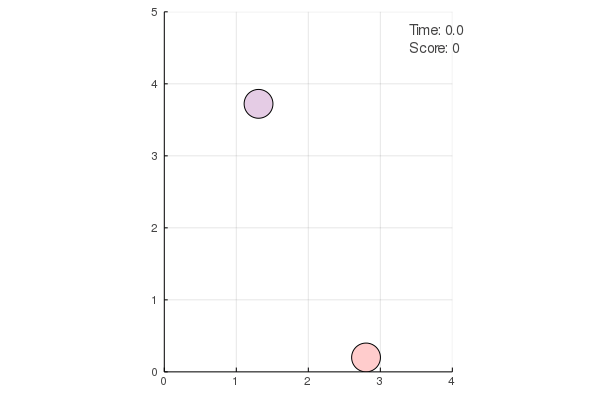

In [25]:
game(brain=model, time=20)

### Study Topics:
1. Use Neural Networks to build an `AI-pilot` for **Mars Lander** in assigment 4 in Lecture 4 ([L4-N-Body-Problem](L4-N-Body-Problem.ipynb)).